### Import library

In [ ]:
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as trasnforms
from torchvision.models import resnet34

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
from PIL import Image

### Set seed

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


set_seed(1998)

### Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_normal_dir = '/content/drive/MyDrive/image_processing_project/train/NORMAL'
train_pneumonia_dir = '/content/drive/MyDrive/image_processing_project/train/PNEUMONIA'
valid_normal_dir = '/content/drive/MyDrive/image_processing_project/valid/NORMAL'
valid_pneumonia_dir = '/content/drive/MyDrive/image_processing_project/valid/PNEUMONIA'

train_normal_filenames = sorted([os.path.join(train_normal_dir, f) for f in os.listdir(train_normal_dir)])
train_pneumonia_filenames = sorted([os.path.join(train_pneumonia_dir, f) for f in os.listdir(train_pneumonia_dir)])
valid_normal_filenames = sorted([os.path.join(valid_normal_dir, f) for f in os.listdir(valid_normal_dir)])
valid_pneumonia_filenames = sorted([os.path.join(valid_pneumonia_dir, f) for f in os.listdir(valid_pneumonia_dir)])

train_filenames = [*train_normal_filenames, *train_pneumonia_filenames]
valid_filenames = [*valid_normal_filenames, *valid_pneumonia_filenames]

print(len(train_filenames))

5216


In [ ]:
train_transforms = A.Compose([A.Resize(height=256, width=256),
                              A.Normalize(mean=[0.5], std=[0.5], max_pixel_value=255.0, p=1.0),
                              ToTensorV2(always_apply=True),])
valid_transforms = A.Compose([A.Resize(height=256, width=256),
                              A.Normalize(mean=[0.5], std=[0.5], max_pixel_value=255.0, p=1.0),
                              ToTensorV2(always_apply=True),])

In [ ]:
class XrayDataset(Dataset):
    def __init__(self, filenames, transforms):
        self.filenames = filenames
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        img = Image.open(img_path)
        if img.mode == "RGB":
            img = img.convert("L")
        img = np.array(img)
        transformed_img = self.transforms(image=img)["image"]
        label = 0 if "IM" in img_path else 1
        return transformed_img, label

In [ ]:
train_dataset = XrayDataset(train_filenames, train_transforms)
valid_dataset = XrayDataset(valid_filenames, valid_transforms)

train_size = round(len(train_dataset)*0.8)
valid_size = len(train_dataset) - train_size

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset,
                          batch_size=64,
                          num_workers=2,
                          shuffle=True)
valid_loader = DataLoader(valid_dataset,
                          batch_size=64,
                          num_workers=2,
                          shuffle=False)

In [ ]:
inputs, label = next(iter(train_loader))
print(inputs.size())
print(label)

torch.Size([64, 1, 256, 256])
tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1])


### Load model

In [ ]:
class ResNet34(nn.Module):
    def __init__(self, num_classes):
        super(ResNet34, self).__init__()
        self.model = resnet34(weights='DEFAULT')
        self.num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(self.num_ftrs, num_classes)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = ResNet34(num_classes=2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 72.8MB/s]


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-05, betas=(0.9, 0.999), eps=1e-08)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model = model.to(device)
criterion = criterion.to(device)

cuda:0


### Train

In [ ]:
def train(model, train_loader, valid_loader, optimizer, criterion, num_epochs):
    best_acc = 0.0
    best_epoch = 1

    global train_loss
    global train_acc
    global valid_loss
    global valid_acc
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    for epoch in range(num_epochs):
        print("-" * 40)
        print(f"Epoch : {epoch+1}/{num_epochs}")
        epoch_loss = 0.0
        epoch_corrects = 0
        model.train()
        for batch_in, batch_out in train_loader:
            batch_in = batch_in.to(device)
            batch_out = batch_out.to(device)

            y_pred = model(batch_in)
            _, preds = torch.max(y_pred, 1)

            loss = criterion(y_pred, batch_out)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_in.size(0)
            epoch_corrects += torch.sum(preds == batch_out.data)

        epoch_loss = epoch_loss / len(train_loader.dataset)
        epoch_acc = epoch_corrects.double() / len(train_loader.dataset)

        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        print(f"train Loss : {epoch_loss:.4f} Acc : {epoch_acc:.4f}")

        epoch_loss = 0.0
        epoch_corrects = 0
        model.eval()
        for batch_in, batch_out in valid_loader:
            batch_in = batch_in.to(device)
            batch_out = batch_out.to(device)

            with torch.no_grad():
                y_pred = model(batch_in)
                _, preds = torch.max(y_pred, 1)

                loss = criterion(y_pred, batch_out)

                epoch_loss += loss.item() * batch_in.size(0)
                epoch_corrects += torch.sum(preds == batch_out.data)

        epoch_loss = epoch_loss / len(valid_loader.dataset)
        epoch_acc = epoch_corrects.double() / len(valid_loader.dataset)

        valid_loss.append(epoch_loss)
        valid_acc.append(epoch_acc)

        scheduler.step()

        if epoch_acc >= best_acc:
            best_acc = epoch_acc
            best_epoch = epoch + 1
            torch.save(
                model, "/content/drive/MyDrive/image_processing_project/model.pt"
            )

        print(f"valid Loss : {epoch_loss:.4f} Acc : {epoch_acc:.4f}")
        print(f"best Acc : {best_acc:.4f}")
        print(f"best Epoch : {best_epoch}")
        print("-" * 40)
        print()


train(model, train_loader, valid_loader, optimizer, criterion, num_epochs=20)

----------------------------------------
Epoch : 1/20
train Loss : 0.2433 Acc : 0.9152
valid Loss : 0.1578 Acc : 0.9492
best Acc : 0.9492
best Epoch : 1
----------------------------------------

----------------------------------------
Epoch : 2/20
train Loss : 0.0786 Acc : 0.9782
valid Loss : 0.0977 Acc : 0.9636
best Acc : 0.9636
best Epoch : 2
----------------------------------------

----------------------------------------
Epoch : 3/20
train Loss : 0.0343 Acc : 0.9933
valid Loss : 0.0826 Acc : 0.9703
best Acc : 0.9703
best Epoch : 3
----------------------------------------

----------------------------------------
Epoch : 4/20
train Loss : 0.0208 Acc : 0.9962
valid Loss : 0.0827 Acc : 0.9722
best Acc : 0.9722
best Epoch : 4
----------------------------------------

----------------------------------------
Epoch : 5/20
train Loss : 0.0096 Acc : 0.9995
valid Loss : 0.0850 Acc : 0.9722
best Acc : 0.9722
best Epoch : 5
----------------------------------------

-------------------------

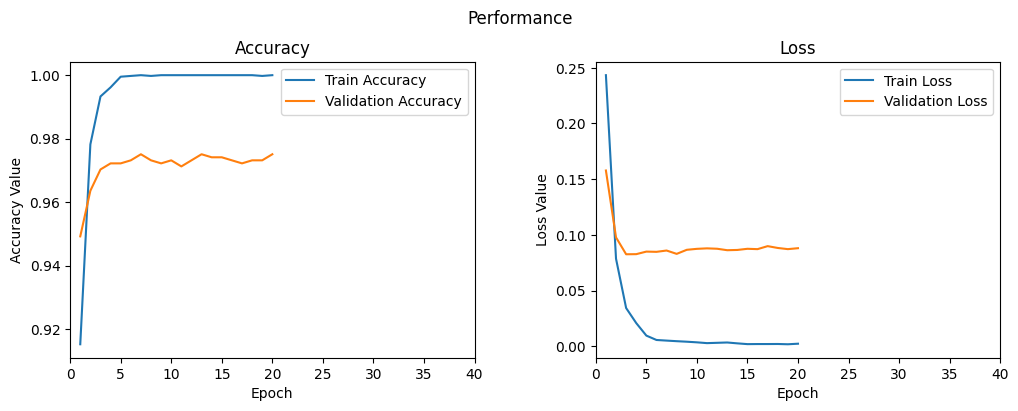

In [ ]:
import matplotlib.pyplot as plt

train_acc = [acc.cpu().numpy() for acc in train_acc]
valid_acc = [acc.cpu().numpy() for acc in valid_acc]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

num_epochs = 20
epoch_list = list(range(1,num_epochs+1))
ax1.plot(epoch_list, train_acc, label='Train Accuracy')
ax1.plot(epoch_list, valid_acc, label='Validation Accuracy')
ax1.set_xticks(np.arange(0, num_epochs*2+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, train_loss, label='Train Loss')
ax2.plot(epoch_list, valid_loss, label='Validation Loss')
ax2.set_xticks(np.arange(0, num_epochs*2+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### Test

In [ ]:
test_normal_dir = '/content/drive/MyDrive/image_processing_project/test/NORMAL'
test_pneumonia_dir = '/content/drive/MyDrive/image_processing_project/test/PNEUMONIA'

test_normal_filenames = sorted([os.path.join(test_normal_dir, f) for f in os.listdir(test_normal_dir)])
test_pneumonia_filenames = sorted([os.path.join(test_pneumonia_dir, f) for f in os.listdir(test_pneumonia_dir)])

test_filenames = [*test_normal_filenames, *test_pneumonia_filenames]

In [ ]:
test_transforms = A.Compose([A.Resize(height=256, width=256),
                              A.Normalize(mean=[0.5], std=[0.5], max_pixel_value=255.0, p=1.0),
                              ToTensorV2(always_apply=True),])

In [ ]:
class XrayInferenceDataset(Dataset):
    def __init__(self, filenames, transforms):
        self.filenames = filenames
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        img = Image.open(img_path)
        if img.mode == "RGB":
            img = img.convert("L")
        img = np.array(img)
        transformed_img = self.transforms(image=img)["image"]
        img_name = img_path.split("/")[-1]
        return transformed_img, img_name

In [ ]:
test_dataset = XrayInferenceDataset(test_filenames, transforms=test_transforms)

test_loader = DataLoader(test_dataset,
                          batch_size=1,
                          num_workers=2,
                          shuffle=False)

In [ ]:
inputs = next(iter(test_loader))

In [ ]:
def inference(model, test_loader):
    model.eval()
    for batch_in, img_name in test_loader:
        batch_in = batch_in.to(device)

        y_pred = model(batch_in)
        y_pred = F.softmax(y_pred, dim=1)
        _, preds = torch.max(y_pred, 1)

        print(
            f'"{img_name[0]}" : detected nothing'
            if preds[0] == 0
            else f'"{img_name[0]}" : detected an abnormal finding'
        )


model = torch.load("/content/drive/MyDrive/image_processing_project/model.pt")
model.to(device)
inference(model, test_loader)

"NORMAL2-IM-1427-0001.jpeg" : detected nothing
"NORMAL2-IM-1430-0001.jpeg" : detected nothing
"NORMAL2-IM-1431-0001.jpeg" : detected nothing
"NORMAL2-IM-1436-0001.jpeg" : detected an abnormal finding
"NORMAL2-IM-1437-0001.jpeg" : detected nothing
"NORMAL2-IM-1438-0001.jpeg" : detected an abnormal finding
"NORMAL2-IM-1440-0001.jpeg" : detected nothing
"NORMAL2-IM-1442-0001.jpeg" : detected nothing
"person1946_bacteria_4874.jpeg" : detected an abnormal finding
"person1946_bacteria_4875.jpeg" : detected an abnormal finding
"person1947_bacteria_4876.jpeg" : detected an abnormal finding
"person1949_bacteria_4880.jpeg" : detected an abnormal finding
"person1950_bacteria_4881.jpeg" : detected an abnormal finding
"person1951_bacteria_4882.jpeg" : detected an abnormal finding
"person1952_bacteria_4883.jpeg" : detected an abnormal finding
"person1954_bacteria_4886.jpeg" : detected an abnormal finding
